In [7]:
# auto reload
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from compute_transition import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


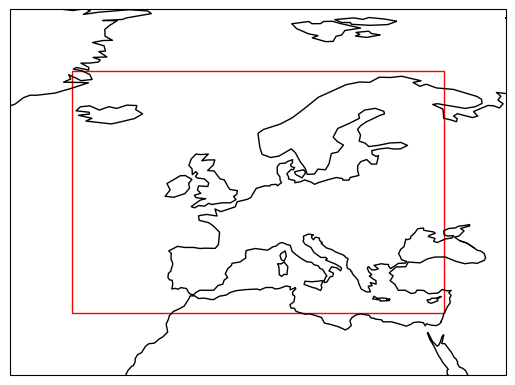

In [22]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
domain = [-25, 35, 33, 72]
ax.add_patch(plt.Rectangle((domain[0], domain[2]), domain[1]-domain[0], domain[3]-domain[2], fill=False, edgecolor="red", transform=ccrs.PlateCarree()))
# add padding to the domain
padding = 10
extent = [domain[0]-padding, domain[1]+padding, domain[2]-padding, domain[3]+padding]
ax.set_extent(extent, crs=ccrs.PlateCarree())

In [31]:
zfile = xr.open_dataset("/home/kbrennan/data/era5/cdf/2024/09/Z20240914_20")

# only keep U and V
zfile = zfile[["U", "V"]]
# crop to the domain
zfile = zfile.sel(lon=slice(extent[0], extent[1]), lat=slice(extent[2], extent[3]))
# only keep 50000 to 90000 Pa
zfile = zfile.sel(plev=slice(50000, 90000))
zfile = zfile.squeeze()

In [32]:
zfile

<xarray.Dataset> Size: 921kB
Dimensions:  (plev: 6, lat: 119, lon: 161)
Coordinates:
  * lon      (lon) float32 644B -35.0 -34.5 -34.0 -33.5 ... 43.5 44.0 44.5 45.0
  * lat      (lat) float32 476B 23.0 23.5 24.0 24.5 25.0 ... 80.5 81.0 81.5 82.0
  * plev     (plev) float64 48B 5e+04 6e+04 7e+04 8e+04 8.5e+04 9e+04
    time     datetime64[ns] 8B 2024-09-14T20:00:00
Data variables:
    U        (plev, lat, lon) float32 460kB ...
    V        (plev, lat, lon) float32 460kB ...
Attributes:
    CDI:          Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Sat Jan 11 14:52:04 2025: cdo -b F32 -f nc4c -z zip -t ecmw...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/...

In [83]:
# compute the transition matrix
transition_matrix = compute_transition_indices(zfile,2*3600)

Text(0.5, 1.0, 'Histogram of Transition Distances')

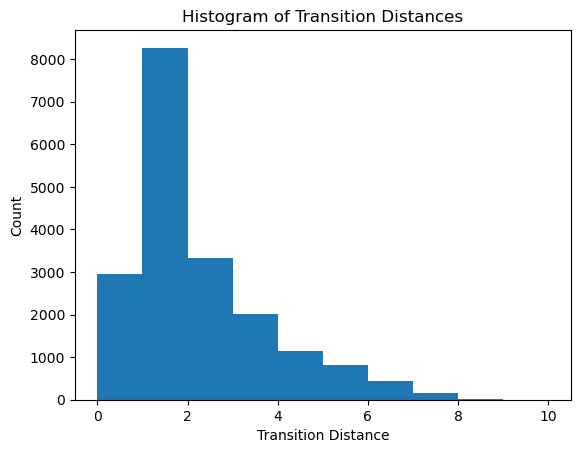

In [84]:
# histogram transition index distance
distances = []
for i in range(0, transition_matrix.shape[2]):
    for j in range(0, transition_matrix.shape[3]):
        distances.append(np.sqrt((transition_matrix[0,-1,i,j]-i)**2 + (transition_matrix[1,-1,i,j]-j)**2))

plt.hist(distances, bins=[0, 1, 2, 3, 4, 5,6,7,8,9,10])
plt.xlabel("Transition Distance")
plt.ylabel("Count")
plt.title("Histogram of Transition Distances")

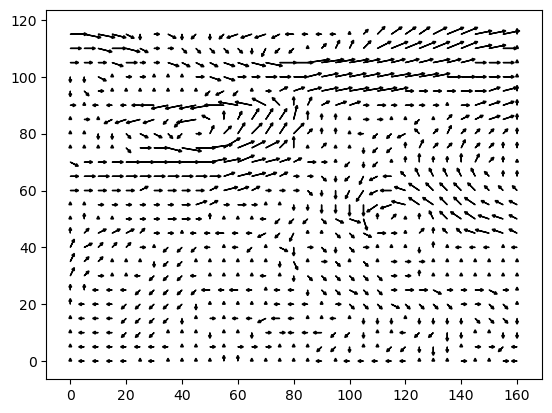

In [86]:
fig, ax = plt.subplots()

i_plev = -1
skip = 5
for i in range(0, transition_matrix.shape[2], skip):
    for j in range(0, transition_matrix.shape[3], skip):
        ax.arrow(
            j,
            i, 
            transition_matrix[1,i_plev,i,j]-j,
            transition_matrix[0,i_plev,i,j]-i,
            head_width=1,
            head_length=1,
            fc='k',
            ec='k'
        )